In [1]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import xarray  as xr

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi'] = 300

version = "no_transform"
# version = "sqrt"
# version = "transform_0.1"

# !scp bp:samples_{version}.pt .

test = xr.open_dataset("test.nc").pr.values
samples = torch.load(f"samples_{version}.pt", map_location=torch.device('cpu')).numpy()

test_cells_sorted = torch.load("test_flattened_sorted.pt").numpy()
samples_cells_sorted = np.sort(samples.flatten())

test_frames = test.reshape(-1, 64 * 64)
test_frames_mean = np.mean(test_frames, axis=1)
test_frames_mean_sorted = np.sort(test_frames_mean)
samples_frames = samples.reshape(-1, 64 * 64)
samples_frames_mean = np.mean(samples_frames, axis=1)
samples_frames_mean_sorted = np.sort(samples_frames_mean)

test_videos = test.reshape(-1, 10 * 64 * 64)
test_videos_mean = np.mean(test_videos, axis=1)
test_videos_mean_sorted = np.sort(test_videos_mean)
samples_videos = samples.reshape(-1, 10 * 64 * 64)
samples_videos_mean = np.mean(samples_videos, axis=1)
samples_videos_mean_sorted = np.sort(samples_videos_mean)

print(samples.shape)

(2960, 1, 10, 64, 64)


In [2]:
def get_quantiles(sorted_array, desired_quantiles):
    indices = (len(sorted_array) - 1) * desired_quantiles
    indices_floor = np.floor(indices).astype(int)
    indices_ceil = np.ceil(indices).astype(int)

    indices_fractional_part = indices - indices_floor

    quantiles_floor = sorted_array[indices_floor]
    quantiles_ceil = sorted_array[indices_ceil]

    quantiles = quantiles_floor + indices_fractional_part * (quantiles_ceil - quantiles_floor)

    return quantiles

def plot_qq(test_quantiles, samples_quantiles, log = False):
    plt.figure(figsize=(6, 6))
    plt.scatter(test_quantiles, samples_quantiles, marker = 'x', s = 5, linewidth = 0.5, label = "Actual")
    # plt.plot(test_quantiles, samples_quantiles, linewidth = 0.5, label = "Actual")
    plt.plot(test_quantiles, test_quantiles, linewidth = 0.5, linestyle=":", c = "black", label = "Ideal")
    plt.legend()

    plt.xscale('log' if log else 'linear')
    plt.yscale('log' if log else 'linear')
    
    plt.xlabel('UKCP18 Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
    plt.ylabel('Generated Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

    plt.savefig("examples/qq.pdf", bbox_inches='tight', pad_inches=0.02)
    plt.show()

# # desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-1, -8, -1)])
# desired_quantiles = 1 - np.geomspace(1, 0.0000001, 100)
# # desired_quantiles = 1 - np.geomspace(1, 0.1, 100)
# # print(desired_quantiles)

# test_cells_quantiles = get_quantiles(test_cells_sorted, desired_quantiles)
# samples_cells_quantiles = get_quantiles(samples_cells_sorted, desired_quantiles)

# test_frames_quantiles = get_quantiles(test_frames_mean_sorted, desired_quantiles)
# samples_frames_quantiles = get_quantiles(samples_frames_mean_sorted, desired_quantiles)

# test_videos_quantiles = get_quantiles(test_videos_mean_sorted, desired_quantiles)
# samples_videos_quantiles = get_quantiles(samples_videos_mean_sorted, desired_quantiles)

# print("QQ Plot for Individual Cells:")
# plot_qq(test_cells_quantiles, samples_cells_quantiles)
# # print("QQ Plot for Frame Averages:")
# # plot_qq(test_frames_quantiles, samples_frames_quantiles)
# # print("QQ Plot for Video Averages:")
# # plot_qq(test_videos_quantiles, samples_videos_quantiles)

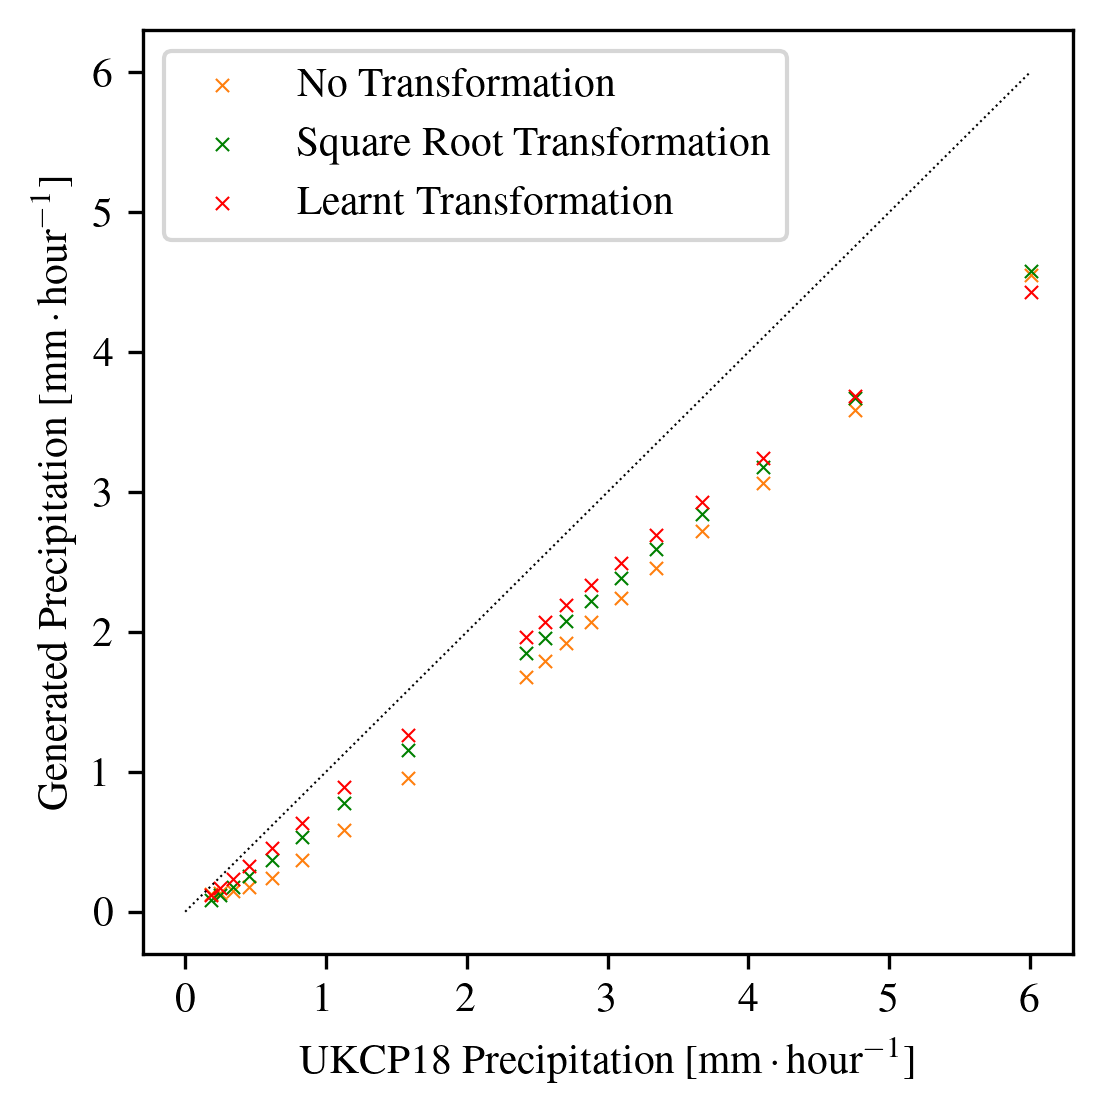

In [7]:
test = xr.open_dataset("test.nc").pr.values
samples_no_transform = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu')).numpy()
samples_sqrt = torch.load(f"samples_sqrt.pt", map_location=torch.device('cpu')).numpy()
samples_transform = torch.load(f"samples_transform_0.1.pt", map_location=torch.device('cpu')).numpy()

test_cells_sorted = torch.load("test_flattened_sorted.pt").numpy()
samples_no_transform_cells_sorted = np.sort(samples_no_transform.flatten())
samples_sqrt_cells_sorted = np.sort(samples_sqrt.flatten())
samples_transform_cells_sorted = np.sort(samples_transform.flatten())

# # desired_quantiles = 1 - np.geomspace(1, 0.0000001, 100)
desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-2, -4, -1)])
# desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-4, -8, -1)])
# desired_quantiles = np.array([0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90])

test_cells_quantiles = get_quantiles(test_cells_sorted, desired_quantiles)
samples_no_transform_cells_quantiles = get_quantiles(samples_no_transform_cells_sorted, desired_quantiles)
samples_sqrt_cells_quantiles = get_quantiles(samples_sqrt_cells_sorted, desired_quantiles)
samples_transform_cells_quantiles = get_quantiles(samples_transform_cells_sorted, desired_quantiles)

plt.figure(figsize=(4, 4))
plt.scatter(test_cells_quantiles, samples_no_transform_cells_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "No Transformation", c = "#ff7f0e")
plt.scatter(test_cells_quantiles, samples_sqrt_cells_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "Square Root Transformation", c = "green")
plt.scatter(test_cells_quantiles, samples_transform_cells_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "Learnt Transformation", c = "red")
plt.plot([0, test_cells_quantiles[-1]], [0, test_cells_quantiles[-1]], linewidth = 0.5, linestyle=":", c = "black")
plt.legend()

plt.xlabel('UKCP18 Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
plt.ylabel('Generated Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

plt.savefig("examples/qq.png", bbox_inches='tight', pad_inches=0.02)
plt.show()

(4208, 1, 10, 64, 64) (2960, 1, 10, 64, 64)


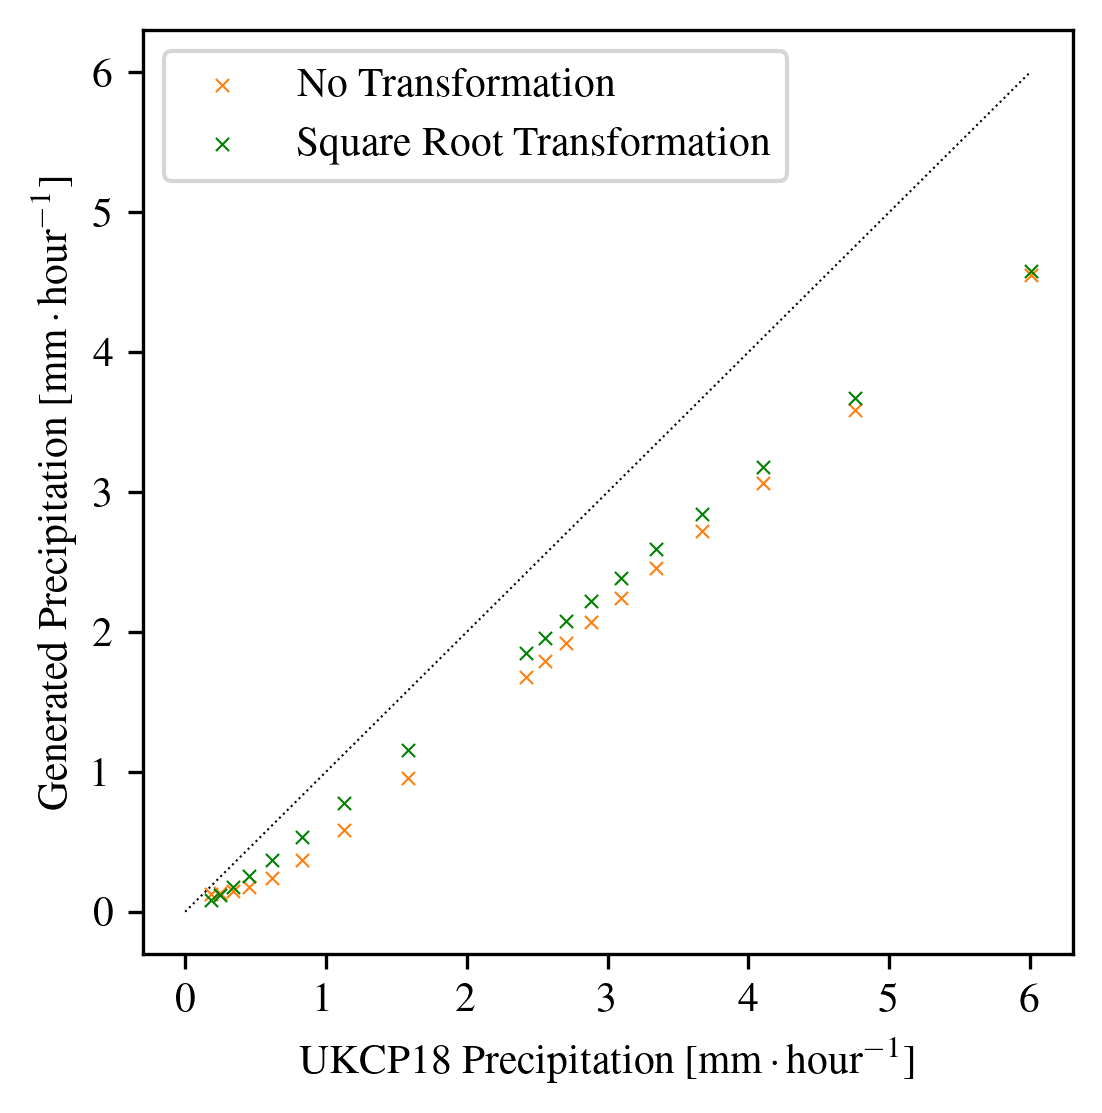

In [25]:
test = xr.open_dataset("test.nc").pr.values
samples_no_transform = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu')).numpy()
samples_sqrt = torch.load(f"samples_sqrt.pt", map_location=torch.device('cpu')).numpy()
print(samples_sqrt.shape, samples_no_transform.shape)

test_cells_sorted = torch.load("test_flattened_sorted.pt").numpy()
samples_sqrt_cells_sorted = np.sort(samples_sqrt.flatten())
samples_no_transform_cells_sorted = np.sort(samples_no_transform.flatten())

# desired_quantiles = 1 - np.geomspace(1, 0.0000001, 100)
desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-2, -4, -1)])
# desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-4, -8, -1)])

test_cells_quantiles = get_quantiles(test_cells_sorted, desired_quantiles)
samples_sqrt_cells_quantiles = get_quantiles(samples_sqrt_cells_sorted, desired_quantiles)
samples_no_transform_cells_quantiles = get_quantiles(samples_no_transform_cells_sorted, desired_quantiles)

plt.figure(figsize=(4, 4))
plt.scatter(test_cells_quantiles, samples_no_transform_cells_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "No Transformation", c = "#ff7f0e")
plt.scatter(test_cells_quantiles, samples_sqrt_cells_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "Square Root Transformation", c = "green")
plt.plot([0, test_cells_quantiles[-1]], [0, test_cells_quantiles[-1]], linewidth = 0.5, linestyle=":", c = "black")
plt.legend()

plt.xlabel('UKCP18 Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
plt.ylabel('Generated Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

plt.savefig("examples/qq.png", bbox_inches='tight', pad_inches=0.02)
plt.show()

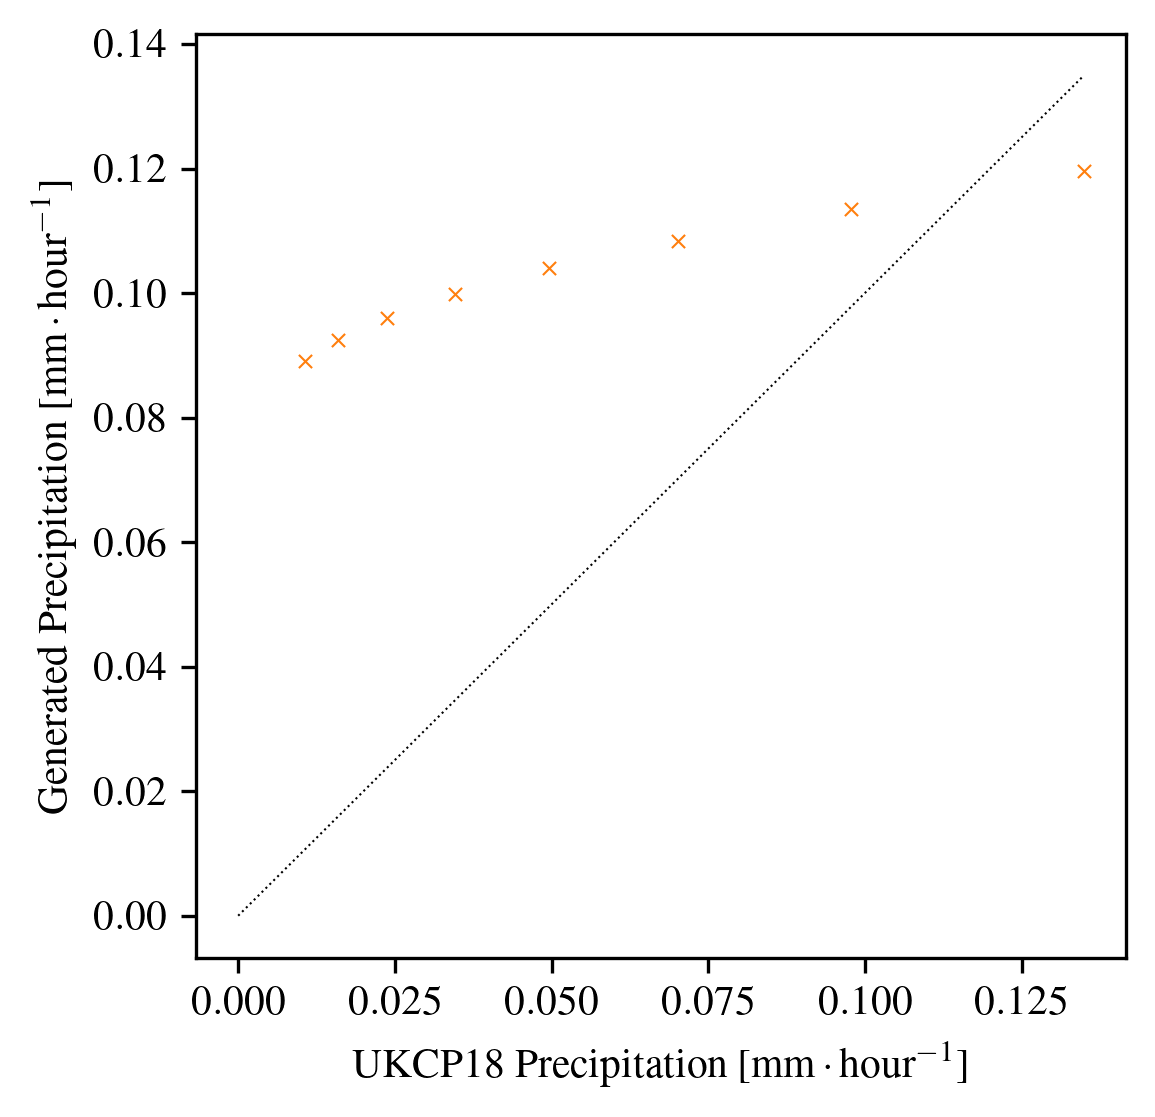

In [4]:
test = xr.open_dataset("test.nc").pr.values
samples_no_transform = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu')).numpy()

test_cells_sorted = torch.load("test_flattened_sorted.pt").numpy()
samples_no_transform_cells_sorted = np.sort(samples_no_transform.flatten())

# desired_quantiles = 1 - np.geomspace(1, 0.0000001, 100)
# desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-2, -4, -1)])
# desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-4, -8, -1)])

test_cells_quantiles = get_quantiles(test_cells_sorted, desired_quantiles)
samples_no_transform_cells_quantiles = get_quantiles(samples_no_transform_cells_sorted, desired_quantiles)

plt.figure(figsize=(4, 4))
plt.scatter(test_cells_quantiles, samples_no_transform_cells_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "No Transformation", c = "#ff7f0e")
plt.plot([0, test_cells_quantiles[-1]], [0, test_cells_quantiles[-1]], linewidth = 0.5, linestyle=":", c = "black")
# plt.legend()

plt.xlabel('UKCP18 Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
plt.ylabel('Generated Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

plt.savefig("examples/qq.png", bbox_inches='tight', pad_inches=0.02)
plt.show() 

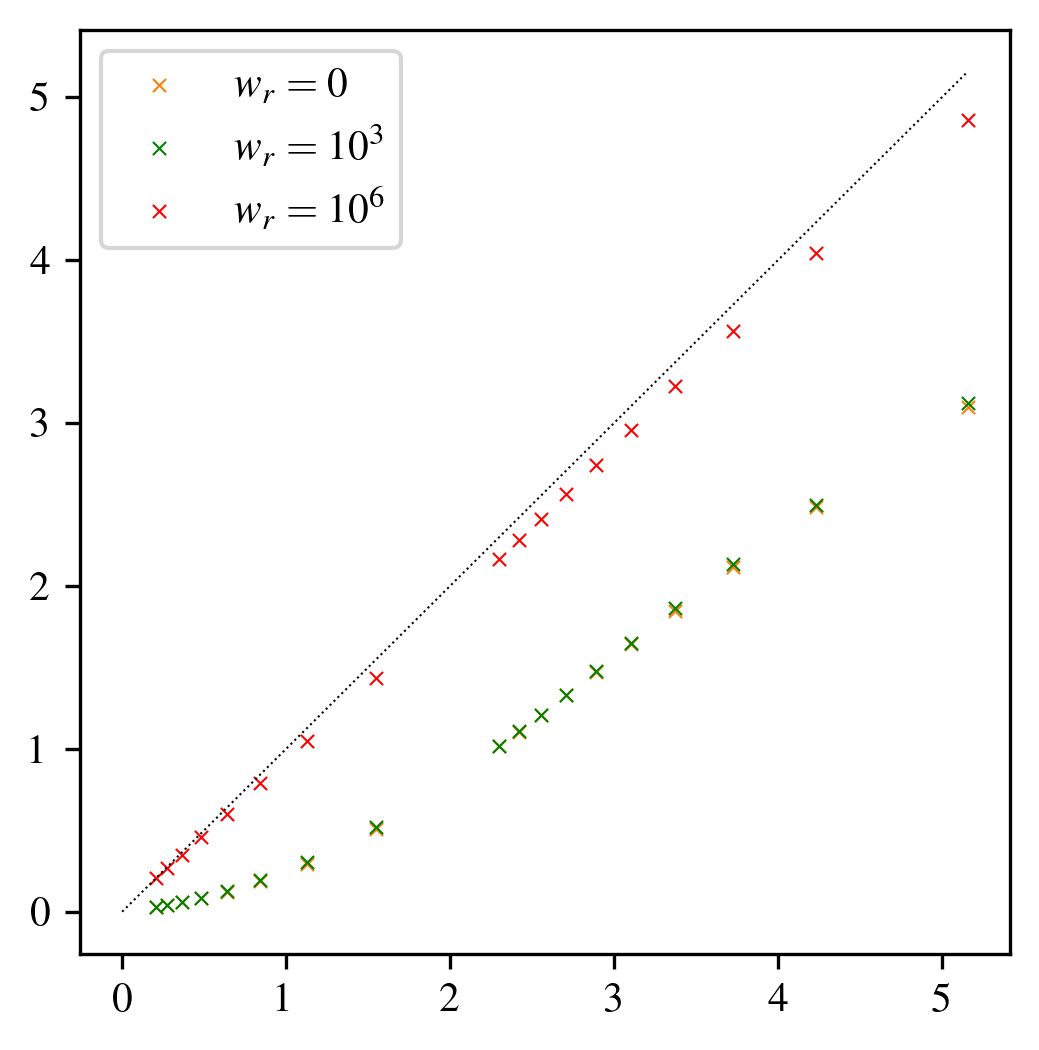

In [9]:
# !scp bp:cond_sample_recon_0.pt cond_sample/
# !scp bp:cond_sample_recon_1000.pt cond_sample/
# !scp bp:cond_sample.pt cond_sample/ 

interpolate_0 = torch.load("cond_sample/cond_sample_recon_0.pt")
interpolate_1k = torch.load("cond_sample/cond_sample_recon_1000.pt")
interpolate_1m = torch.load("cond_sample/cond_sample.pt")

min_samples = min(interpolate_0.shape[0], interpolate_1k.shape[0], interpolate_1m.shape[0])
interpolate_0 = interpolate_0[:min_samples]
interpolate_1k = interpolate_1k[:min_samples]
interpolate_1m = interpolate_1m[:min_samples]

num_frames = interpolate_1m.shape[0] * 10

test = xr.open_dataset("test.nc").pr.isel(time = slice(0, num_frames)).values
test = test.reshape(-1, 1, 10, 64, 64)

indexes = [1, 3, 5, 7, 9]
# indexes = [0, 2, 4, 6, 8]
interpolate_0 = interpolate_0[:, 0, indexes, :, :]
interpolate_1k = interpolate_1k[:, 0, indexes, :, :]
interpolate_1m = interpolate_1m[:, 0, indexes, :, :]
test = test[:, 0, indexes, :, :]

interpolate_0 = interpolate_0.flatten()
interpolate_1k = interpolate_1k.flatten()
interpolate_1m = interpolate_1m.flatten()
test = test.flatten()

# desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-4, -8, -1)])
desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-2, -4, -1)])

interpolate_0_quantiles = get_quantiles(np.sort(interpolate_0), desired_quantiles)
interpolate_1k_quantiles = get_quantiles(np.sort(interpolate_1k), desired_quantiles)
interpolate_1m_quantiles = get_quantiles(np.sort(interpolate_1m), desired_quantiles)
test_quantiles = get_quantiles(np.sort(test), desired_quantiles)

plt.figure(figsize=(4, 4))
plt.scatter(test_quantiles, interpolate_0_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "$w_r = 0$", c = '#ff7f0e')
plt.scatter(test_quantiles, interpolate_1k_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "$w_r = 10^{3}$", c = 'green')
plt.scatter(test_quantiles, interpolate_1m_quantiles, marker = 'x', s = 10, linewidth = 0.5, label = "$w_r = 10^{6}$", c = 'red')
plt.legend()
plt.plot([0, test_quantiles[-1]], [0, test_quantiles[-1]], linewidth = 0.5, linestyle=":", c = "black")
plt.show()